# RGI10 (Asia North)

F. Maussion & S. Galos, June-December 2021

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist, open_zip_shapefile
import os

## Files and storage paths

In [2]:
# Region of interest
reg = 10

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '10_rgi60_NorthAsia.zip')

In [3]:
# Specific to this region: boxes where data has to be selected differently
support_dir = os.path.join(data_dir, 'l0_support_data')

# OK path to file
box_file = os.path.join(support_dir, 'rgi10_boxes.zip')

### Load the input data

In [4]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [5]:
sdf, df_cat = submission_summary(shp)
sdf

,N,A,analysts,submitters,release_date,geog_area,src_date_mode,src_date_min,src_date_max
subm_id,,,,,,,,,
357,182,156.0,Kapustin,Khromova,2006,Siberian Mountains,2003,2003,2003
382,80,61.0,Kapustin,Khromova,2006,Russian Glaciers (exact boundaries of RC to be...,2001,2001,2001
408,138,54.6,Muravyev,Khromova,2007,Russian Glaciers (exact boundaries of RC to be...,2000,2000,2000
506,79,88.6,Muravyev,Khromova,2008,Siberian Mountains,2004,2004,2004
507,206,176.5,Muravyev,Khromova,2008,Siberian Mountains,2004,2004,2004
570,690,436.6,Pan,Kamp,2013,Mongolia,1989,1989,1991
571,716,429.1,Pan,Kamp,2013,Mongolia,2000,1998,2001
572,668,367.5,Pan,Kamp,2013,Mongolia,2011,2010,2011
583,285,187.7,"Guo, Liu",Liu,2014,China,2006,2006,2008


- 636 is RGI6
- 698 is GAMDAMv2 - we use it
- 726 is a mapping of a few remaining nominal glaciers on three De Long Islands
- 743 is an update of the Barr inventory for Kamchatka

In [6]:
# # Optional: write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

## Outline selection 

In [7]:
glims_rgi = shp.loc[shp.subm_id.isin([636])].copy()
glims_rgi['is_rgi6'] = True
all_others = shp.loc[shp.subm_id.isin([698, 726, 743])].copy()
all_others['is_rgi6'] = False

In [8]:
# Preselected areas to remove
box = open_zip_shapefile(support_dir + '/rgi10_boxes.zip')

In [9]:
# Remove the new regions from rgi
rp = glims_rgi.representative_point()
rp = rp.to_frame('geometry')
rp['orig_index'] = glims_rgi.index
difference = gpd.overlay(rp, box, how='difference')
glims_rgi = glims_rgi.loc[difference['orig_index']].copy()

In [10]:
# Size filter?
needs_size_filter(glims_rgi), needs_size_filter(all_others)

(False, True)

In [11]:
print(len(all_others))
all_others = size_filter(all_others)
print(len(all_others))

5469
5467


In [12]:
rgi7 = pd.concat([glims_rgi, all_others])

### Some sanity checks 

In [13]:
sdf, df_class = submission_summary(rgi7)
df_class

,N,N NA
subm_id,,
636,1646,1646
698,2984,2984
726,12,12
743,2471,2471


In [14]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    check = np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())
    if np.any(check):
        print(f'Orphan rock outcrops detected in subm_id {rgi7.subm_id.unique()[check]}')
        orphan_f['area'] = orphan_f.to_crs({'proj':'cea'}).area

### Plots 

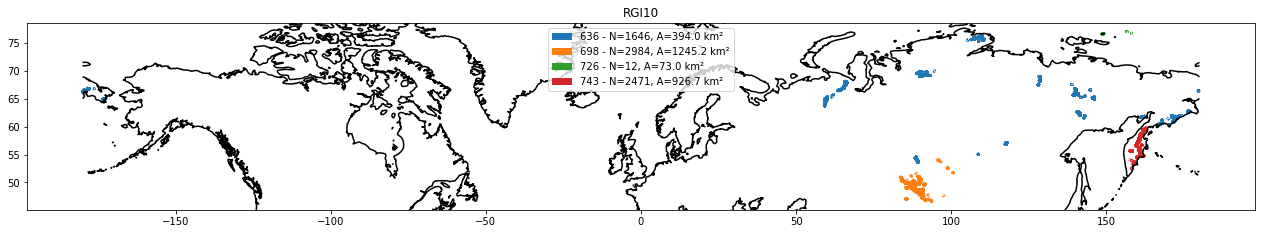

In [15]:
plot_map(rgi7, reg, figsize=(22, 10), linewidth=3, loc='upper center')

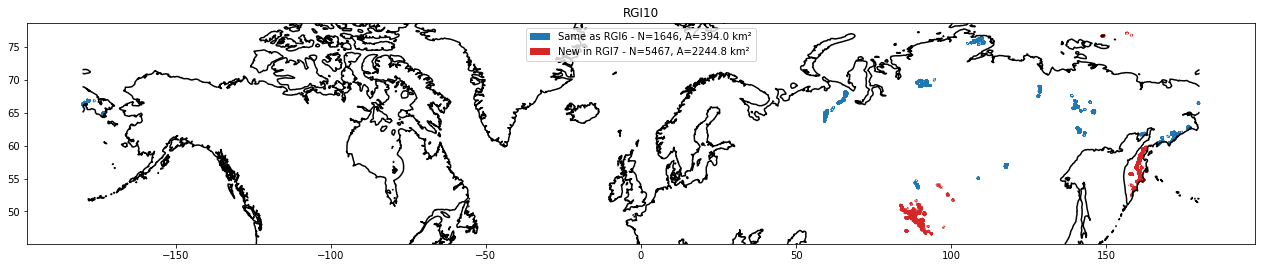

In [16]:
plot_map(rgi7, reg, figsize=(22, 10), linewidth=3, loc='upper center', is_rgi6=True)

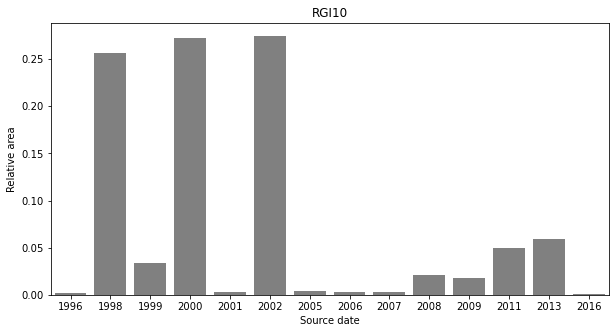

In [17]:
plot_date_hist(rgi7, reg)

### Text for github

In [18]:
fgh = sdf.T
fgh

subm_id,636,698,726,743
N,1646,2984,12,2471
A,394.0,1245.2,73.0,926.7
analysts,"Cogley, Earl, Gardner, Raup",Sakai,Kochtitzky,"Barr, Khromova, Paul, Rastner"
submitters,Cogley,Sakai,Kochtitzky,Paul
release_date,2015,2018,2021,2021
geog_area,Randolph Glacier Inventory; Umbrella RC for me...,Asia,Canada,Various (GlobGlacier)
src_date_mode,2013,2002,1999,2000
src_date_min,1999,1996,1999,2000
src_date_max,2013,2008,2000,2016


In [19]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 636                                                                    | 698    | 726        | 743                           |
|:--------------|:-----------------------------------------------------------------------|:-------|:-----------|:------------------------------|
| N             | 1646                                                                   | 2984   | 12         | 2471                          |
| A             | 394.0                                                                  | 1245.2 | 73.0       | 926.7                         |
| analysts      | Cogley, Earl, Gardner, Raup                                            | Sakai  | Kochtitzky | Barr, Khromova, Paul, Rastner |
| submitters    | Cogley                                                                 | Sakai  | Kochtitzky | Paul                          |
| release_date  | 2015                                                                   | 2018   | 2021       | 2021             

## Write out and tar 

In [20]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI10.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI10'], returncode=0)


## Consistency check with RGI6 

In [21]:
rgi6 = open_zip_shapefile(rgi6_reg_file)

In [22]:
len(rgi7), len(rgi6)

(7113, 5151)

Test the areas:

In [23]:
rgi6['area'] = rgi6.to_crs({'proj':'cea'}).area 

In [24]:
print('Area RGI7a (km2)', rgi7['area'].sum() * 1e-6)
print('Area RGI6 (km2)', rgi6['area'].sum() * 1e-6)
print('diff areas RGI6 - RGI7 computed by us (km2)', (rgi6['area'].sum() - rgi7['area'].sum()) * 1e-6)

Area RGI7a (km2) 2638.8268520969764
Area RGI6 (km2) 2410.021788898029
diff areas RGI6 - RGI7 computed by us (km2) -228.80506319894695


In [25]:
# Remove the ids
rp = rgi6.representative_point()
rp = rp.to_frame('geometry')
rp['orig_index'] = rgi6.index

difference = gpd.overlay(rp, box, how='difference')
rgi6_old = rgi6.loc[difference['orig_index']].copy()
difference = gpd.overlay(rp, box, how='intersection')
rgi6_new = rgi6.loc[difference['orig_index']].copy()
assert len(rgi6_new) + len(rgi6_old) == len(rgi6)

In [26]:
print(f'N1 = {len(rgi6_old)} , N2 = {len(glims_rgi)}')
print('Area RGI7 (km2)', glims_rgi['area'].sum() * 1e-6)
print('Area RGI6 (km2)', rgi6_old['area'].sum() * 1e-6)
print('diff', (rgi6_old['area'].sum() - glims_rgi['area'].sum()) * 1e-6)

N1 = 1646 , N2 = 1646
Area RGI7 (km2) 394.0329721890614
Area RGI6 (km2) 394.0330784789445
diff 0.00010628988313674926
